In [20]:
#%% Paket för att lösa HUPP:en %%#

# Standard paket för att hantera matamatik och arrayer
import numpy as np

# Vi lånar funktionen repmat från matlib
from numpy.matlib import repmat

# Standard paket för att plotta figurer
import matplotlib.pyplot as plt

# Scipy constants innehåller alla möjliga fysikaliska konstanter
# Vi använder det för att importera ljusets hastighet
from scipy import constants
c = constants.speed_of_light

In [21]:
#%% Funktioner för att lösa HUPP:en %%#

def xy_source(N, D_star, seperation):
    '''
        
    N:          Antalet observationspunkter (punkter längs u-axeln där fältet beräknas)
    D_star:     Stjärnans diameter [m]
    separation: Avstånd mellan punktkällorna på stjärnan [m],
                kan lämpligen anges som bråkdel av D_star, 
                t.ex. separation=D_star/30
        
    x: matris med punktkällornas x-positioner [m] 
    y: matris med punktkällornas y-positioner [m]
    M: punktkällornas antal
    
    '''

    x = np.arange(-D_star/2, D_star/2 + seperation, seperation) # Vektor med källpunkter i x-led
    y = x                                                       # och i y-led
    
    X, Y = np.meshgrid(x, y)                                    
    R    = np.sqrt(X**2 + Y**2)                                 # Längd från origo till källpunkter
    
    element_inuti_diameter = R < (D_star/2)                     # Element innanför D_star

    x = X[element_inuti_diameter]                               # Plocka ut x-koordinater som är innanför D_star
    y = Y[element_inuti_diameter]                               # och plocka ut y-koordinater

    M = np.sum(element_inuti_diameter)                          # Totalt antal källor innanför D_star
    
    return (x, y, M)

def plot_xy_source(x ,y, M):
    '''
    Skapar en figur som visar hur xy-source är placerade

    '''
    theta = np.linspace(0, 2*np.pi, 100)                      # Rita en cirkel med diameter D_star
    x_circumference = D_star/2*np.cos(theta)
    y_circumference = D_star/2*np.sin(theta)
    
    
    miljon_km = 1e6*1e3                                       # Skala om axlar till miljoner km
    
    x_miljon_km = x/miljon_km
    y_miljon_km = y/miljon_km
    
    x_circumference_miljon_km = x_circumference/miljon_km
    y_circumference_miljon_km = y_circumference/miljon_km
    
    plt.figure(10)
    plt.axis('equal')
    
    plt.plot(x_circumference_miljon_km, y_circumference_miljon_km, 'black')
    plt.plot(x_miljon_km, y_miljon_km, 'ro', markersize=1.4)
    
    plt.title(r'Källpositioner på stjärna. Antal källor M = ' + str(M))
    plt.xlabel('x [miljoner km]')
    plt.ylabel('y [miljoner km]')

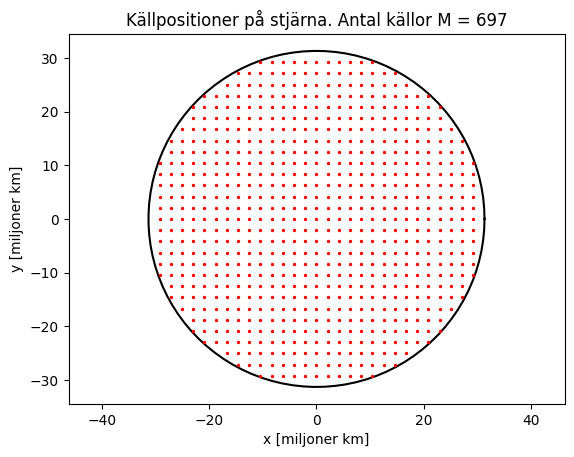

In [68]:
#%% Definiera variabler och generera källor %%#

iterationer = 1000                                       # Antal iterationer/koherenstider. Använda >200 minst!
N           = 100                                       # Punkter längs u-axeln

sek_per_ar = 365.24*24*60*60                            # Sekunder på ett år
L_70  = 70*sek_per_ar*c                                 # 70 ljusår  [m]
L_300 = 300*sek_per_ar*c                                # 300 ljusår [m]


lam0  = 650e-9                                          # Våglängd [m]
k0    = 2*np.pi/lam0                                    # Vågtal   [1/m]


### Genererar källor från stjärna ###
D_sol         = 1392700e3

D_star        = 45*D_sol
# D_star        = 60*D_sol

separation    = D_star/30                               # Separation mellan källor på stjärna
# separation    = D_star/3
# separation    = D_star/100

x, y, M = xy_source(N, D_star, separation)              # Generera x och y positioner för källor
plot_xy_source(x ,y, M)                                 # Plotta stjärna med källor

### Punkter som observeras ###
u = np.linspace(0, 20, N)   
u = u.reshape(N, 1)                                     # Reshape till kolonvektor

### Skapa repeterade matriser för att undvika loopar ###
x_repeterad = repmat(x, N, 1)
y_repeterad = repmat(y, N, 1)                      
u_repeterad = repmat(u, 1, M) 

### Distans till observations punkter ###
r = -(x_repeterad/L_70)*u_repeterad                   # Ledning finns i HUPP-beskrivning 

(0.0, 1.1)

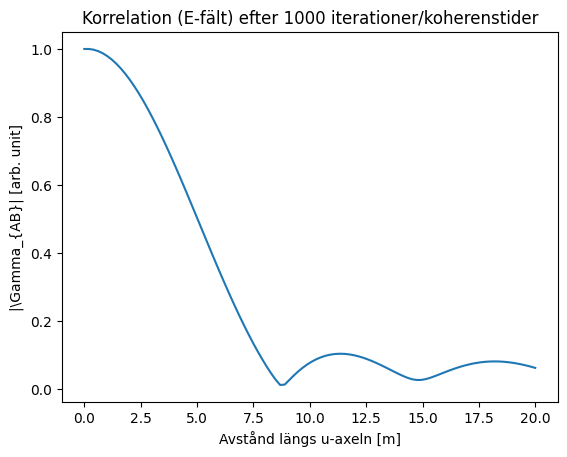

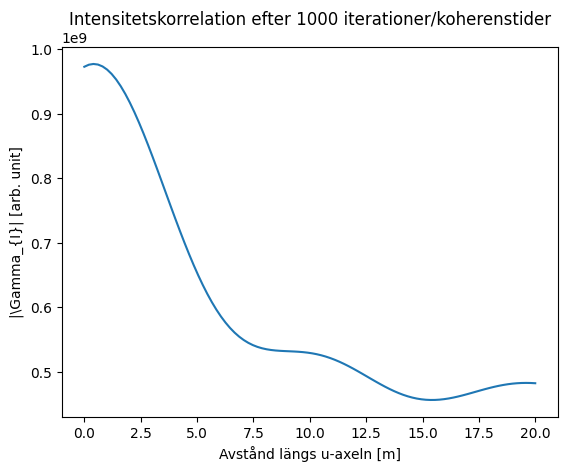

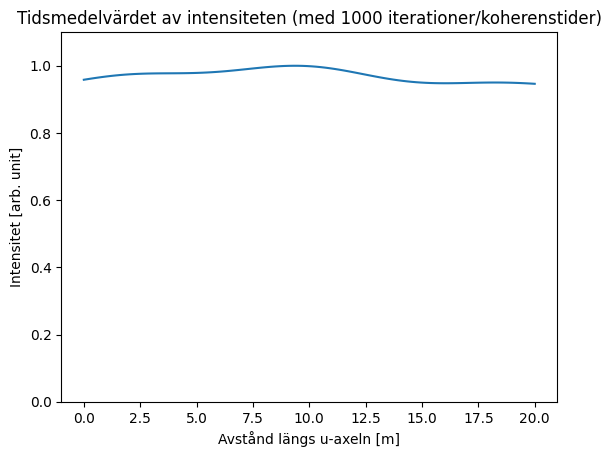

In [69]:
#%% Summera koherenstider %##
### Initiera variabler ###
gamma   = 0                # Korrelation <E(0,0)conj(E(u,0))>
I_tot   = 0                # Tidsmedelvärdesbildad intensitet
gamma_I = 0                # Intensitetskorrelation <I(0,0)conj(I(u,0))>


### Loopa över w koherenstider ###
for i in range(iterationer):
    ### Generera slumpmässig fas ###
    fas           = 2*np.pi*np.random.rand(M, 1)
    fas_repeterad = np.transpose(repmat(fas, 1, N))
    
    ### Observerade värden ###
    E_k_obs       = np.exp(1j*(fas_repeterad + k0*r))        # Given i HUPP-beskrivning
    E_obs         = np.sum(E_k_obs, 1)        # Given i HUPP-beskrivning
    inst_produkt  = E_obs[0]*np.conj(E_obs)        # Given i HUPP-beskrivning
    
    gamma         = gamma + inst_produkt        # E-fältets korrelation (amplitud o fas), summera inst_produkt i varje iteration!
    I_tot         = I_tot + np.abs(E_obs)**2        # Tidsmedelvärdesbildad intensitet, summera np.abs(E_obs)**2 över alla koherenstider
    gamma_I       = gamma_I + (np.abs(E_obs[1])**2)*np.conj(np.abs(E_obs)**2)       # Intensitetskorrelation, samma som Gamma fast med I = np.abs(E_obs(1))**2 och np.abs(E_obs)**2


gamma_norm = np.abs(gamma/np.max(gamma))

plt.figure(1)
plt.plot(u, gamma_norm)
plt.title(r'Korrelation (E-fält) efter ' + str(iterationer) + ' iterationer/koherenstider')
plt.xlabel (r'Avstånd längs u-axeln [m]')
plt.ylabel(r'|\Gamma_{AB}| [arb. unit]')



gamma_I_norm = np.abs(gamma_I/np.max(gamma_I))

plt.figure(2)
plt.plot(u, gamma_I)
plt.title('Intensitetskorrelation efter ' + str(iterationer) + ' iterationer/koherenstider' )
plt.xlabel ('Avstånd längs u-axeln [m]')
plt.ylabel('|\Gamma_{I}| [arb. unit]')




I_tot_norm = np.abs(I_tot/np.max(I_tot))

plt.figure(3)
plt.plot(u, I_tot_norm)
plt.title('Tidsmedelvärdet av intensiteten (med ' + str(iterationer) + ' iterationer/koherenstider)' )
plt.xlabel ('Avstånd längs u-axeln [m]')
plt.ylabel('Intensitet [arb. unit]')

plt.ylim([0, 1.1])

In [67]:
l_s_1 = 8.1
D_star_1 = 45*D_sol

const = D_star_1*l_s_1/(lam0*L_70)
print(const)

l_s_2 = 6.0
D_star_2 = 60*D_sol
const = D_star_2*l_s_2/(lam0*L_70)
print(const)

1.179318013096179
1.164758531453016


In [71]:
#%% Uppgift e

# koherenslängden l_s = ? är utläst från bilden i texten till HUPP 4 
# första nollstället när ränderna är svåra att urskilja, finns två ställen
# på bilden i HUPP-beskrivningen
l_s = 3.36

D_star_e = const*lam0*L_300/l_s
print(f'Röd jättestjärnas diameter = {D_star_e}')
# D_star i antal soldiametrar
print(f'Röd jättestjärna i antal soldiamterar: {D_star_e/(2*696342e3)}')

Röd jättestjärnas diameter = 639505102040.8163
Röd jättestjärna i antal soldiamterar: 459.1889488504329
